# PHYS305 project: Object tracking in 2D and 3D using Kalman Filters

Project objectives:

- Implement different variants of a Kalman Filter: **Linear Kalman Filter** for simple motion models, and **Extended Kalman Filter** for nonlinear motion.
- Simulate object motion and noisy sensor measurements (e.g., from a camera or radar). Specifically, simulate:
    - 2D and 3D motion of an object with constant but unknown velocity, with cartesian coordinate measurements.
    - 2D and 2D motion of an object under aerodynamic drag, with range and bearning measurements.
- Run a suitable variant of a Kalman Filter on simulated object motion data.
- Evaluate the Kalman Filter tracking accuracy and computational efficiency under different noise conditions.

The code and examples below are a starting point for further exploration.

*For enquiries, e-mail **Prof. Costas Andreopoulos** <c.andreopoulos @ cern.ch>*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  
from scipy.stats import norm

## The Linear Kalman Filter 

The Linear Kalman Filter (LKF) is a recursive algorithm the predicts the evolution of a dynamic system, combining a model about that system and noisy measurements about the state of the system.

Assume that,
at the point $u_k$ of a suitable coordinate,
a system is described by the state vector 
$\displaystyle s_k = s(u_k)$.

If the system is linear, the evolution of the state vector can be expressed as

$\displaystyle s_k = 
\cal{F}_{k-1} s_{k-1} + w_{k-1}$

where

$\cal{F}$ is *state transition model*, and the vector
$w$ encapsulates inherent process disturbances that corrupt 
the evolution of the system.

At the coordinate $u_k$, an observation of the system results in a measurment vector $m_k$ given by

$\displaystyle m_k = \cal{H}_{k} s_{k} + \epsilon_{k}$

where 

$\cal{H}$ is the *observation model*, and
$\epsilon$ is the measurement noise vector.

Generally, we assume that all components of $w$ and $\epsilon$ are normally distributed, unbiased and uncorrelated. Let $\cal{Q}$ be the covariance of the process noise, and $\cal{R}$ the covariance of the measurement noise:

$\displaystyle E[w_k \cdot w_k^T] = \cal{Q}_k$

$\displaystyle E[\epsilon_k \cdot \epsilon_k^T] = \cal{R}_k$

The covariance matrix corresponding to the state vector $s_k$ is defined as

$\displaystyle E[s_k \cdot s_k^T] = \cal{C}_k$

The LKF procedure proceeds as follows:

- **Seeding:** Generate an initial estimate for the state vector, $s_0$, 
and covariance matrix $\cal{C}_0$.

- **A priori estimation:** Produce an *a priori* estimate of the state vector, $\hat{s}_k$ and covariance matrix, $\hat{\cal{C}}_k$ at the next step, using only information about the dynamical evolution of the system and no measurements:

    $\hat{s}_k = \cal{F}_{k-1} s_{k-1}$
    
    $\hat{\cal{C}}_k = \cal{F}_{k-1} \cal{C}_{k-1} \cal{F}_{k-1}^T + \cal{Q}_{k-1}$
    
- **Correction:** Update the state vector, $s_k$ and covariance matrix $\cal{C}_k$ incorporating information obtained through the measurement process. We write the corrected values as:

    $s_k = \hat{s}_k + \cal{K}_k \Big(m_k - \cal{H}_k \hat{s}_k\Big)$
    
    $\cal{C}_k = \Big(\cal{I} - \cal{K}_k \cal{H}_k\Big)\hat{\cal{C}}_k$
    
    where $\cal{K}_k$ is the *Kalman gain*, derived by minimizing $\cal{C}_k$. This minimization can be done analytically, and the Kalman gain is given by:
    
    $\cal{K}_k = \hat{\cal{C}}_k \cal{H}_k^T \Big(\cal{R}_k + \cal{H}_k \hat{\cal{C}}_k \cal{H}_k^T \Big)^{-1}$

In [2]:
def linear_kalman_filter(F,Q,H,R,ml,s0,C0):
    """
    A simple implementation of a Kalman Filter (KF).
    Inputs:
    - F:  State transition model, represented as a numpy array with shape (Ns,Ns)
    - Q:  Process noise covariance, represented as a numpy array with shape (Ns,Ns)    
    - H:  Observation model, represented as a numpy array with shape (Nm,Ns)
    - R:  Measurement noise covariance, represented as a numpy array with shape (Nm,Nm)
    - ml: A list of N measurements, with each one stored as a flattened numpy array with shape (Nm,)
    - s0: An initial estimate of the state vector, represented as a flattened numpy array with shape (Ns,)
    - C0: An initial estimate of the covariance matrix corresponding to the state vector, 
          represented as a numpy array with shape (Ns,Ns)
    Outputs:
    - sl: A list of state vector estimates, produced at the coordinate of each of the N input 
          measurements. Each output state vector is flattened, and converted from (Ns,1) to (Ns,) shape.
    - Cl: A list of estimates of the covariance matrix corresponding to the state vector, 
          produced at the coordinate of each of the N input measurements. Each covariance is represented
          as a numpy array with shape (Ns,Ns)
    """
    sl = [] # output list of state vectors
    Cl = [] # output list of covariances

    Ns = F.shape[0] # number of elements in each state vector
    Nm = H.shape[0] # number of elements in each measurement vector

    I = np.eye(Ns)
    s = s0.copy().reshape(Ns,1) # convert to column vector
    C = C0.copy()
    
    for m in ml:
        # Prediction step
        s = F @ s
        C = F @ C @ F.T + Q
        
        # Calculation of Kalman Gain
        S = H @ C @ H.T + R
        K = C @ H.T @ np.linalg.inv(S)        

        # Update step
        s = s + K @ (m.reshape(Nm, 1) - H @ s)
        C = (I - K @ H) @ C

        sl.append(s.flatten())
        Cl.append(C)

    return sl, Cl    

## The Extended Kalman Filter 

Many real-world systems are not linear. The Extended Kalman Filter (EKF) is version of the Kalman Filter that is applicable to such non-linear systems. 

In general, the state transition and observation processes are not simple linear functions of the state $s$ and, therefore,
the state transition model, $\cal{F}$, and the observation model, $\cal{H}$, do not have a simple, fixed representation as arrays. 
However, the state transition and observation process may still be described by general, differentiable functions.

Let $\cal{f}$ be a nonlinear state transition function describing the evolution of the state vector from $s_{k-1} = s(u_{k-1})$ to $s_{k} = s(u_{k})$

$\displaystyle s_k = \cal{f}(s_{k-1}, u_{k}) + w_{k-1}$

and $\cal{h}$ be a nonlinear measurement function mapping a state $s_k$ to a measurement $m_k$

$\displaystyle m_k = \cal{h}(s_{k}) + \epsilon_{k}$.


In this general case, the matrices representing the state transition model, $\cal{F}$, and the observation model, $\cal{H}$, are given by the following Jacobians

$\displaystyle \cal{F} = \frac{\partial \cal{f}}{\partial s}$, and
$\displaystyle \cal{H} = \frac{\partial \cal{h}}{\partial s}$ 

The Jacobian $\displaystyle \frac{\partial \phi}{\partial x}$ of a function 
$\phi(x_0,x_1,...,x_{M-1}) = \Big(\phi_0(x_0,x_1,...,x_{M-1}),\phi_1(x_0,x_1,...,x_{M-1}),...,\phi_{N-1}(x_0,x_1,...,x_{M-1}) \Big)$
is an $N \times M$ matrix given by

$
\displaystyle \frac{\partial \phi}{\partial x} =
\begin{pmatrix}
\displaystyle \frac{\partial \phi_0}{\partial x_0} & 
... &  
\displaystyle \frac{\partial \phi_0}{\partial x_{M-1}} \\
... & 
... & 
... \\
\displaystyle \frac{\partial \phi_{N-1}}{\partial x_0} & 
... & 
\displaystyle \frac{\partial \phi_{N-1}}{\partial x_{M-1}} \\
\end{pmatrix}
$ 


In [3]:
def jacobian(f,x,epsilon=1E-7):
    """
    Calculate the Jacobian, J, of the input vector function f(x) = (f_0(x),f_1(x),...,f_{n-1}(x)),
    where x is the m-dimensional vector (x_0,x_1,...,x_{m-1}). 
    The vector x is represented as a numpy array with shape (m,).
    The function f(x) returns all the components of the function as a numpy array with shape (n,).
    The output Jacobian is a numpy array with a shape of (n,m).
    """
    n = len(f(x))
    m = len(x)
    J = np.zeros((n,m))
    # loop over the component of vector \vec{x} 
    for i in range(m): 
        # At turn i, get a (m,) array with its i^th element tweaked: xp = [x_0 ... x_i+epsilon ... x_{m-1}]
        xp = x.copy()
        xp[i] += epsilon         
        # Calculate the derivative wrt to x_i for all components of f, at the input x.
        # i.e. get [df_0/dx_i ... df_{n-1}/dx_i] as a numpy array with shape (n,).
        df_dx = (f(xp)-f(x))/epsilon
        # Reshape the above (n,) array to become the i^th column of the Jacobian matrix.
        # J[:,i:i+1] = df_dx.reshape(n,1) # i:i+1 keeps J[:,i:i+1] as a column vector; J[:,i] is flattened
        J[:,i] = df_dx 
    # print(f"J = {J}")    
    return J

In [4]:
def extended_kalman_filter(f,q,h,r,ml,s0,C0):
    """
    An implementation of an Extended Kalman Filter (EKF).
    Inputs:
    - f:  A general, possibly non-linear state transition function evolving the state vector 
          s_k to s_{k+1} = f(s_k,u_k).
    - q:  A function that computes the process noise covariance.  
          The q function accepts the state vector as a numpy array with shape (Ns,) 
          and returns the process noise covariance as an array with shape (Ns,Ns).
    - h:  A general, possibly non-linear measurement function mapping the state vector s_k 
          to a noise-less measurement m_k = h(s_k).
          The h function accepts the state vector as a numpy array with shape (Ns,) 
          and returns the measurement as an array with shape (Nm,).          
    - r:  A function that computes the measurement noise covariance.
          The r function accepts the state vector as a numpy array with shape (Ns,) 
          and returns the measurement noise covariance as an array with shape (Nm,Nm).
    - ml: A list of N measurements, with each one stored as numpy array with shape (Nm,)
    - s0: An initial estimate of the state vector, represented as a numpy array with shape (Ns,).
    - C0: An initial estimate of the covariance matrix corresponding to the state vector, 
          represented as a numpy array with shape (Ns,Ns).
    Outputs:
    - sl: A list of state vector estimates, produced at the coordinate of each of the N input 
          measurements. Each output state vector is represented as a numpy array with (Ns,) shape.
    - Cl: A list of estimates of the covariance matrix corresponding to the state vector, 
          produced at the coordinate of each of the N input measurements. Each covariance is 
          represented as a numpy array with shape (Ns,Ns)    
    """

    sl = [] # output list of state vectors
    Cl = [] # output list of covariances

    Ns = s0.shape[0]
    Nm = h(s0).shape[0]
        
    I = np.eye(Ns)
    s = s0.copy()
    C = C0.copy()
    
    for m in ml:
        
        # Prediction step
        # ---------------

        # Calculate the state transition matrix, F, taking the Jacobian of f(s).
        # Note that F us estimated using the state s prior to any update.
        F = jacobian(f,s) 
        # print(f"EKF: State transition matrix F:\n {F}")                
        
        # Update the state vector.
        # Calling f(s), rather than calculating F @ s, since the system is non linear.
        # The transition matrix computed above is used only for the estimation of the state covariance.
        s = f(s) 
        # print(f"EKF: predicted s = {s}")          

        # Get the process noise covariance.
        # This may not be a constant matrix, but an adaptive one based on the current state.
        Q = q(s)
        # print(f"EKF: Process noise covariance:\n {Q}")        

        # Update the state covariance.
        C = F @ C @ F.T + Q

        # Calculation of Kalman Gain
        # --------------------------
        
        # Calculate the observation matrix H, taking the Jacobian of f(s).
        H = jacobian(h,s)        
        # print(f"EKF: Observation matrix H:\n {F}")        

        # Get the measurement noise covariance.
        # This may not be a fixed matrix, but an adaptive one based on the current state.
        R = r(s)
        # print(f"EKF: Measurement noise covariance:\n {R}")        

        S = H @ C @ H.T + R
        K = C @ H.T @ np.linalg.inv(S)

        # def angle_wrap(angle):
        #     return (angle + np.pi) % (2 * np.pi) - np.pi  # Keeps angle in [-π, π]
    
        # Correction step
        # ---------------

        # print(f"EKF: incorporating actual measurement m = {m}")        

        # Calculate the anticipated measurement for the current predicted state
        mp = h(s) 

        # Convert m, mp, and s to column vectors
        mpc = mp.reshape(Nm,1)
        sc  = s.reshape(Ns,1) 
        mc  = m.reshape(Nm,1)

        # Calculate corrected state and state covariance
        sc = sc + K @ (mc - mpc)
        C  = (I - K @ H) @ C

        s  = sc.flatten()
        # print(f"EKF: corrected s = {s}")

        sl.append(s)
        Cl.append(C)

    return sl, Cl    

**Code to visualise the inputs and the results of the application of a Kalman Filter**

The following code can be used to visualise true and estimated trajectories and measurements, and to evaluate the accuracy of the Kalman Filter predictions, for all examples exploted in this notebook.

In [21]:
def plot_trajectories_and_measurements(stl, sl, ml, convert_to_cartesian=False, label="object tracking with a Kalman Filter"):
    """
    Visualise true and estimated trajectories in 2D or 3D space, and overlay measurements.
    The code accepts the following inputs:
    - stl: A list of true state vectors, each of which is a numpy array of shape (Ns,).
           Each element of the list of computed at a different value of a generalized coordinate, typically time.
    - sl:  A list of estimated state vectors, each of which is a numpy array of shape (Ns,).
           These state vector estimates are produced at the same generalized coordinate as the true state vectors. 
    - ml:  A list of measurements, each of which is a numpy array of shape (Ns,).
           The measurements correspond to the same generalized coordinate as the true state vectors.
    - convert_to_cartesian: If in the KF we used measurements of range and bearing, a conversion to cartesian
           coordinates is required for overlaying them on the trajectories. 
    """    
    # convert to numpy arrays for convenience
    stl = np.array(stl) # list of true state vectors
    sl  = np.array(sl)  # list of state vectors returned by KF
    ml  = np.array(ml)  # list of measurements  
    ndim = int(sl.shape[1]/2)

    # object tracking in 2D
    if ndim == 2:
        # range and bearing measurements converted to cartesian coordinates
        mlt = np.zeros_like(ml)
        if(convert_to_cartesian):
            mlt[:,0] = ml[:,0] * np.cos(ml[:,1]) # x
            mlt[:,1] = ml[:,0] * np.sin(ml[:,1]) # y 
        else:
            mlt = ml

        # Plot the measurements as well as the true and estimated trajectory in (x,y) space
        plt.figure(figsize=(8, 6))
        plt.plot   (stl[:, 0], stl[:, 1], c='green',  label="True trajectory")
        plt.scatter(mlt[:, 0], mlt[:, 1], c='red',    label="Noisy measurements")
        plt.plot   (sl [:, 0], sl [:, 1], c='blue',   label="Kalman Filter estimate")
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.title(label)
        plt.legend()
        plt.grid()
        plt.show()

    # object tracking in 3D
    if ndim == 3:
        # convert measurements from spherical coordinates to cartesian coordinates
        mlt = np.zeros_like(ml)
        if(convert_to_cartesian):
            mlt[:,0] = ml[:,0] * np.cos(ml[:,1]) * np.sin(ml[:,2]) # x
            mlt[:,1] = ml[:,0] * np.sin(ml[:,1]) * np.sin(ml[:,2]) # y 
            mlt[:,2] = ml[:,0] * np.cos(ml[:,2])                   # z
        else:
            mlt = ml            

        # Plot the measurements as well as the true and estimated trajectory in (x,y,z) space
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot   (stl[:, 0], stl[:, 1], stl[:, 2], c='green',  label="True trajectory")
        ax.scatter(mlt[:, 0], mlt[:, 1], mlt[:, 2], c='red',    label="Noisy measurements", alpha=0.5)
        ax.plot   (sl [:, 0], sl [:, 1], sl [:, 2], c='blue',   label="Kalman Filter estimate")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_ylabel("z (m)")
        ax.set_title(label)
        ax.legend()            
        
        # Now plot the projections on xy, xz and yz planes
        fig = plt.figure(figsize=(8, 3))
        gs = gridspec.GridSpec(1,3, width_ratios=[1, 1, 1])
        ax = [fig.add_subplot(gs[0, i]) for i in range(3)]
        coord_pair  = np.array([[0,1],[0,2],[1,2]])
        coord_label = ["x", "y", "z"]
        for i in range(3):
            ax[i].plot   (stl[:, coord_pair[i,0]], stl[:, coord_pair[i,1]], c='green',  label="True trajectory")
            ax[i].scatter(mlt[:, coord_pair[i,0]], mlt[:, coord_pair[i,1]], c='red',    label="Noisy measurements", alpha=0.5)
            ax[i].plot   (sl [:, coord_pair[i,0]], sl [:, coord_pair[i,1]], c='blue',   label="Kalman Filter estimate")
            ax[i].set_xlabel(f"{coord_label[coord_pair[i,0]]} (m)")
            ax[i].set_ylabel(f"{coord_label[coord_pair[i,1]]} (m)")
            ax[i].legend()
        plt.tight_layout() # Adjust layout
        plt.show()

def plot_trajectory_estimate_deviations(stl,sl,dt):    
    """
    Plot the differences between the true and estimated state vector components.
    The code accepts the following inputs:
    - stl: A list of true state vectors, each of which is a numpy array of shape (Ns,).
           Each element of the list of computed at a different value of a generalized coordinate, typically time.
    - sl:  A list of estimated state vectors, each of which is a numpy array of shape (Ns,).
           These state vector estimates are produced at the same generalized coordinate as the true state vectors.     
    - dt:  Time step used in KF.       
    """
    nsteps = len(sl)
    # convert to numpy arrays for convenience
    stl = np.array(stl) 
    sl  = np.array(sl)        
    ndim = int(sl.shape[1]/2)
    # Plot the distance between the true and estimated trajectory
    fig = plt.figure(figsize=(7 if ndim == 2 else 8, 6))
    gs = gridspec.GridSpec(ndim,2, width_ratios=[1, 1])
    time = np.linspace(dt, nsteps * dt, nsteps) # array of simulation times
    ax = np.array([[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(ndim)])
    coord_label = ["x", "y", "z"]
    for i in range(ndim):
        dpos = sl[:,i] - stl[:,i] # array of x differences, one at each simulation time
        ax[i,0].plot(time, dpos) # plot x difference as a function of time
        ax[i,0].set_xlabel("time (s)")
        ax[i,0].set_ylabel(f"Δ{coord_label[i]} (m)")
        ax[i,0].set_title(f"estimated - true position {coord_label[i]}")
        ax[i,1].hist(dpos, 20, density=True) # plot distribution of position differences
        mu,std = norm.fit(dpos) # gaussian fit to distibution of position differences
        dpos_space = np.linspace(min(dpos),max(dpos),100)
        pdf = norm.pdf(dpos_space,mu,std)
        ax[i,1].plot(dpos_space,pdf,'r') # plot gaussian fit
        ax[i,1].set_title(f"estimated - true position {coord_label[i]}")
        ax[i,1].set_xlabel(f"Δ{coord_label[i]} (m)")
        ax[i,1].set_ylabel("")
    plt.tight_layout() # Adjust layout
    plt.show()

# A simple application of a linear Kalman Filter: 
## Tracking an object moving in 2D or 3D with a constant but unknown velocity.

This section discusses the specifics for applying the general Kalman Filter methodology described above to a simple problem of object tracking in 2D or 3D.

The generalised coordinate $u$ is the time $t$.

In 2D, the state vector at time $t_k$, $s_k = s(t_k)$, is a 4-dimensional vector whose components are the position coordinates $x$ and $y$, and the velocities $\dot{x}=dx/dt$ and $\dot{y}=dy/dt$:

$\displaystyle s_k = 
\begin{pmatrix}
    x\\
    y\\
    \dot{x}\\
    \dot{y}\\
\end{pmatrix}$

If the velocity of the object remains unchanged, the position coordinates evolve as $x \leftarrow x + \dot{x} dt$ and 
$y \leftarrow y + \dot{y} dt$. Therefore, the state transition model is given by:

$\displaystyle \cal{F}_k = 
\begin{pmatrix}
    1 & 0 & dt & 0\\
    0 & 1 & 0 & dt\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & 1\\
\end{pmatrix}$

If we only have access to measurements of the positions, out measurement vector is

$\displaystyle m_k = 
\begin{pmatrix}
    x\\
    y\\
\end{pmatrix}$

Therefore, the observation model mapping state vectors $s_k$ to measurements vectors $m_k$ can be written as

$\displaystyle \cal{H}_k = 
\begin{pmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
\end{pmatrix}$

The above generalizes readily to 3D.

In [22]:
class ConstantVelocityMotion:
    
    def __init__(self, ndim, dt, pnv, mnv, seed=None):
        """
        ndim: number of dimensions (2 or 3)
        dt: time step for the simulation of the dynamic system
        pnv: (2*ndim,) array, with the desired values for the diagonal of the process noise covariance matrix
        mnv: (ndim,) array, with the desired values for the diagonal of the measurement noise covariance matrix
        """
        assert ndim in [2,3]       
        self._Nd = ndim    # number of dimensions
        self._Ns = 2*ndim  # dimensionality of state vector
        self._Nm = ndim    # dimensionality of measurement vector
        self._dt = dt
        # State transition model F
        # represented as a numpy array with shape (Ns,Ns)
        self._F = np.eye(self._Ns)
        for i in range(self._Nd):
            self._F[i,i+self._Nd] = dt
        # Observation model 
        # represented as a numpy array with shape (Nm,Ns)
        self._H = np.zeros((self._Nm,self._Ns))
        for i in range(self._Nd):
            self._H[i,i] = 1
        # Process noise covariance 
        # represented as a numpy array with shape (Ns,Ns) 
        self._Q = np.eye(self._Ns) * pnv
        # Measurement noise covariance 
        # represented as a numpy array with shape (Nm,Nm)
        self._R = np.eye(self._Nm) * mnv
        # Random generator
        self._rng = np.random.default_rng(seed)  

        print(f"Time step dt = \n {self._dt}")
        print(f"State transition model F = \n {self._F}")
        print(f"Process noise covariance Q = \n {self._Q}")
        print(f"Observation model H = \n {self._H}")
        print(f"Measurement noise covariance R = \n {self._R}")

    def generate_true_trajectory(self, N, st0):
        """ 
        Generate a true trajectory, by evolving the input initial state for a number of steps, 
        using the specified state transition model, F,  and process noise covariance, Q.
        Inputs:
        - N : Number of steps
        - st0 : Initial state vector, represented as a numpy array with shape (Ns,)
        Output:
        - A list of N sequential true state vectors. Each state vector in the list is
          represented as a flattened numpy array with shape (Ns,).
        """
        st  = st0.reshape(self._Ns,1)
        stl = []
        F = self._F
        Q = self._Q
        for _ in range(N):
            zeros = np.zeros(self._Ns) # (Ns,)
            noise = self._rng.multivariate_normal(mean=zeros, cov=Q).reshape(self._Ns, 1)    
            st = F @ st + noise
            stl.append(st.flatten())
        return stl

    def generate_noisy_measurements(self, stl):
        """ 
        Generate a list of noisy measurements, using the specified observation model, H, and 
        measurement noise, R, applied to each of the true state vectors of the input list.
        Input:
        - stl: A list of N true state vectors. Each state vector in the list is represented 
          as a numpy array with shape (Ns,).
        Output:  
        - A list of N noisy measurements in 1-1 correspondence with the input state vectors.
          Each measurement in the list is represented as a numpy array with shape (Nm,).
        """    
        ml = []
        H = self._H
        R = self._R
        for st in stl:
            zeros = np.zeros(self._Nm) # (Nm,)
            noise = self._rng.multivariate_normal(mean=zeros, cov=R).reshape(self._Nm, 1)
            m = H @ st.reshape(self._Ns,1) + noise
            ml.append(m.flatten())
        return ml

    def predicted_trajectory(self, ml, s0, C0):
        """
        Apply the Extended Kalman Filter and return the results.
        """
        sl, Cl = linear_kalman_filter(self._F, self._Q, self._H, self._R, ml, s0, C0)
        return sl, Cl                

Time step dt = 
 0.5
State transition model F = 
 [[1.  0.  0.5 0. ]
 [0.  1.  0.  0.5]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
Process noise covariance Q = 
 [[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]
Observation model H = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Measurement noise covariance R = 
 [[20.  0.]
 [ 0. 20.]]


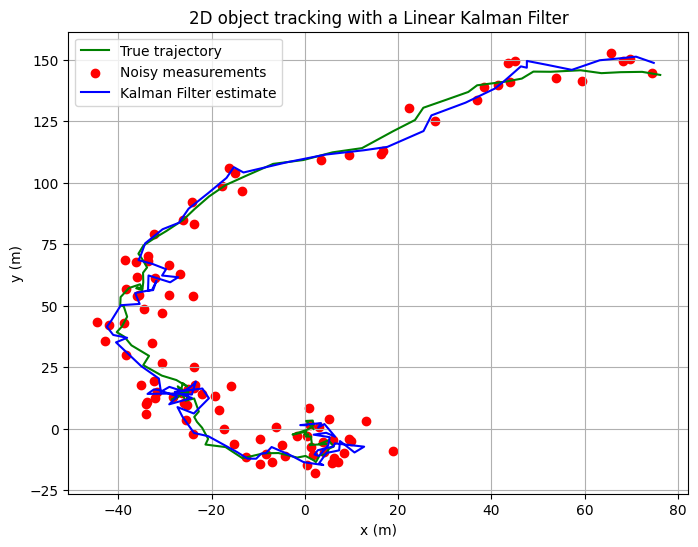

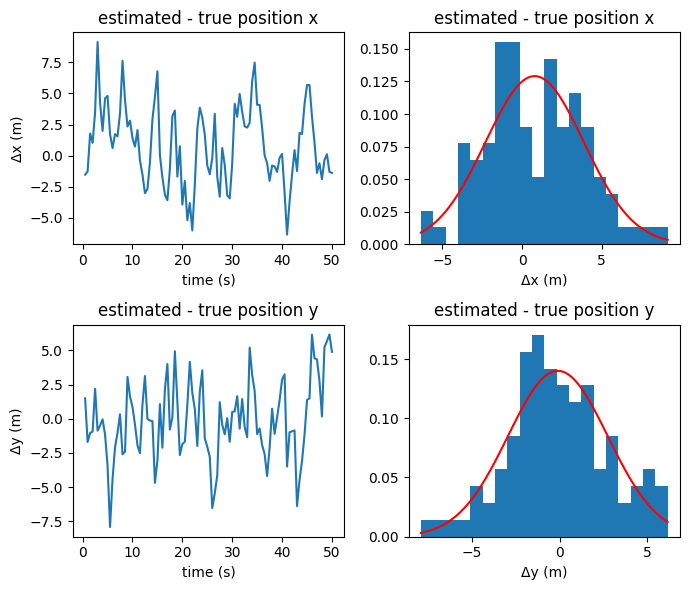

In [23]:
# Inputs for running a 2D example:
# Random number seed (change to None) for randomized seed
seed = 80
# Define time step and total simulation time
dt = 0.5  # Time step (seconds)
N  = 100  # Number of time steps
# True initial state vector
st0 = np.array([0, 0, 1, 1])  # Initial position (0,0) m, velocity (1,1) m/s
# Initial estimates of the state vector and its corresponding covariance matrix
s0 = np.array([0, 0, 0.5, 0.5])  # Initial estimate
C0 = np.eye(4)  # Initial uncertainty
# Process and measurement noise variances
pnv = np.array([2, 2, 2, 2])
mnv = np.array([20, 20])

motion = ConstantVelocityMotion(2,dt,pnv,mnv,seed)

# Generate a true trajectory (a list of N sequential state vectors) by evolving 
# the specified initial state
stl = motion.generate_true_trajectory(N, st0)

# Generate a list of noisy measurements (one for each state vector in the input list).
ml = motion.generate_noisy_measurements(stl)
                
# Apply a linear Kalman Filter to obtain estimates of the state vector and of the 
# corresponding covariance matrix at each time step, given the measurements vectors
sl, Cl = motion.predicted_trajectory(ml,s0,C0)

# Plot
plot_trajectories_and_measurements(stl,sl,ml,False,"2D object tracking with a Linear Kalman Filter")
plot_trajectory_estimate_deviations(stl,sl,dt)   

Time step dt = 
 0.5
State transition model F = 
 [[1.  0.  0.  0.5 0.  0. ]
 [0.  1.  0.  0.  0.5 0. ]
 [0.  0.  1.  0.  0.  0.5]
 [0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  1. ]]
Process noise covariance Q = 
 [[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]
Observation model H = 
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Measurement noise covariance R = 
 [[20.  0.  0.]
 [ 0. 20.  0.]
 [ 0.  0. 20.]]


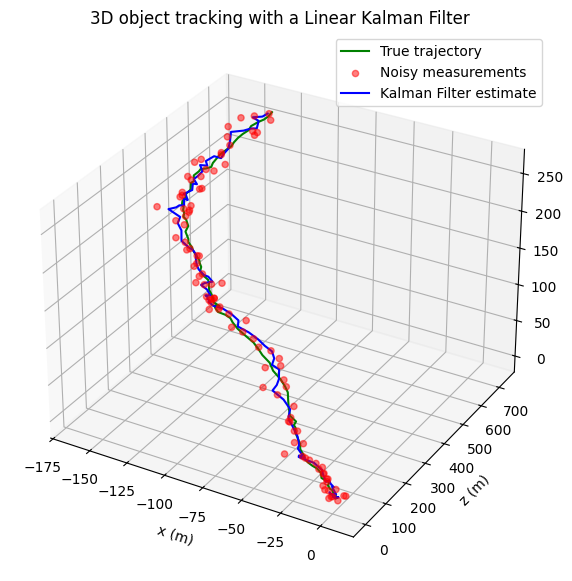

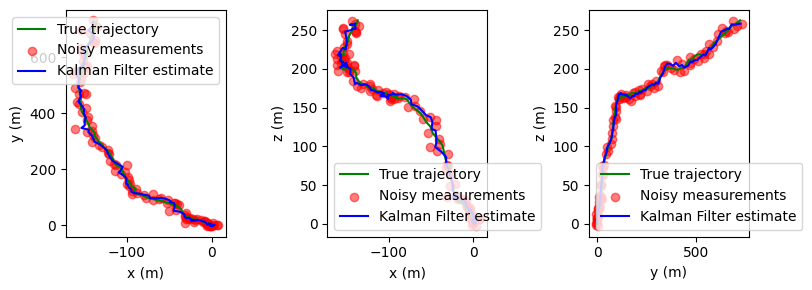

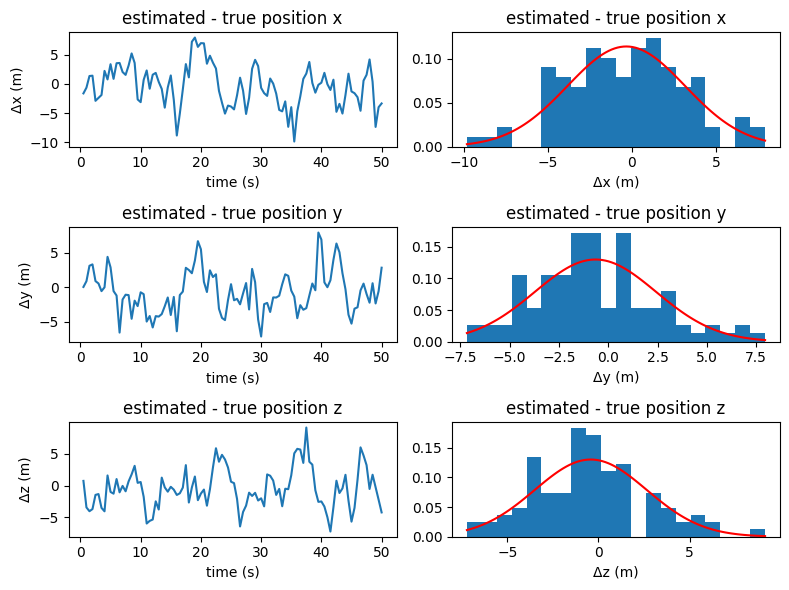

In [24]:
# Inputs for running a 3D example:
# Random number seed (change to None) for randomized seed
seed = 80
# Define time step and total simulation time
dt = 0.5  # Time step (seconds)
N  = 100  # Number of time steps
# True initial state vector
st0 = np.array([0, 0, 0, 1, 1, 1])  # Initial position (0,0) m, velocity (1,1) m/s
# Initial estimates of the state vector and its corresponding covariance matrix
s0 = np.array([0, 0, 0, 0.5, 0.5, 0.5])  # Initial estimate
C0 = np.eye(6)  # Initial uncertainty
# Process and measurement noise variances
pnv = np.array([2, 2, 2, 2, 2, 2])
mnv = np.array([20, 20, 20])

motion = ConstantVelocityMotion(3,dt,pnv,mnv,seed)

# Generate a true trajectory (a list of N sequential state vectors) by evolving 
# the specified initial state
stl = motion.generate_true_trajectory(N, st0)

# Generate a list of noisy measurements (one for each state vector in the input list).
ml = motion.generate_noisy_measurements(stl)
                
# Apply a linear Kalman Filter to obtain estimates of the state vector and of the 
# corresponding covariance matrix at each time step, given the measurements vectors
sl, Cl = motion.predicted_trajectory(ml,s0,C0)

# Plot
plot_trajectories_and_measurements(stl,sl,ml,False,"3D object tracking with a Linear Kalman Filter")
plot_trajectory_estimate_deviations(stl,sl,dt)   

# Applications of the Extended Kalman Filter:  
## Object tracking in 2D and 3D under aerodynamic drag with range and bearing observations.

An interesting problem where both the state transition and observation are non-linear functions of the state vector, is the problem of object tracking in 2D or 3D under aerodynamic drag with range and bearing observations. The Linear Kalman Filter is not a suitable method for this problem, and we will need to employ the Extended Kalman Filter method.

The drag force, $\vec{F}_d$, for an object with mass $m$ and velocity $\vec{v} = (\dot{x},\dot{y})$, is given by
$\displaystyle \vec{F}_{d} = m \frac{d\vec{v}}{dt} = -c_{d} v^2 \hat{v}$
where $c_d$ is the drag coefficient and $\hat{v}$ is a unit vector in the direction of velocity.

Therefore, the update rule for the state vector is now given by

$\displaystyle 
s_k = 
\begin{pmatrix}
    x_k\\
    y_k\\
    \dot{x}_k\\
    \dot{y}_k\\
\end{pmatrix} 
\rightarrow
s_{k+1} =
\begin{pmatrix}
    x_k + \dot{x}_k dt\\
    y_k + \dot{y}_k dt\\
    \dot{x}_k - c \dot{x}_k \sqrt{\dot{x}_k^2+\dot{y}_k^2} dt\\
    \dot{y}_k - c \dot{y}_k \sqrt{\dot{x}_k^2+\dot{y}_k^2} dt\\
\end{pmatrix} 
$
in 2D, or
$\displaystyle 
s_k = 
\begin{pmatrix}
    x_k\\
    y_k\\
    z_k\\
    \dot{x}_k\\
    \dot{y}_k\\
    \dot{z}_k\\    
\end{pmatrix} 
\rightarrow
s_{k+1} =
\begin{pmatrix}
    x_k + \dot{x}_k dt\\
    y_k + \dot{y}_k dt\\
    z_k + \dot{z}_k dt\\
    \dot{x}_k - c \dot{x}_k \sqrt{\dot{x}_k^2+\dot{y}_k^2+\dot{z}_k^2} dt\\
    \dot{y}_k - c \dot{y}_k \sqrt{\dot{x}_k^2+\dot{y}_k^2+\dot{z}_k^2} dt\\
    \dot{z}_k - c \dot{z}_k \sqrt{\dot{x}_k^2+\dot{y}_k^2+\dot{z}_k^2} dt\\
\end{pmatrix} 
$
in 3D.

where $c = c_{d}/m$.

If, instead of measuring the cartesian coordinates $x$ and $y$, we use a radar system providing range and bearing measurements, the measurement operation maps $s_k$ to $m_k$ as follows

$\displaystyle 
s_k = 
\begin{pmatrix}
    x_k\\
    y_k\\
    \dot{x}_k\\
    \dot{y}_k\\
\end{pmatrix} 
\rightarrow
m_k =
\begin{pmatrix}
    r_k \\
    \phi_k
\end{pmatrix} =
\begin{pmatrix}
    \sqrt{x_k + y_k}\\
    tan^{-1}(y_k/x_k)\\
\end{pmatrix} 
$ in 2D, or
$\displaystyle 
s_k = 
\begin{pmatrix}
    x_k\\
    y_k\\
    z_k\\
    \dot{x}_k\\
    \dot{y}_k\\
    \dot{z}_k\\
\end{pmatrix} 
\rightarrow
m_k =
\begin{pmatrix}
    r_k \\
    \phi_k \\
    \theta_k
\end{pmatrix} =
\begin{pmatrix}
    \sqrt{x_k + y_k}\\
    tan^{-1}(y_k/x_k)\\
    tan^{-1}(\sqrt{x_k^2+y_k^2}/z_k)\\
\end{pmatrix} 
$ in 3D.

As it can be seen, both state transition and observation functions are non-linear.

In [25]:
class MotionWithDrag_RangeAndBearingMeasurements:
    
    def __init__(self, ndim, dt, c, q, r, seed=None):
        """
        Inputs:
        - ndim: Number of dimensions (2 or 3)
        - dt: Time step for the simulation of the dynamic system
        - c: Aerodynamic drag / particle mass
        - q: A function that computes the process noise covariance.
        - r: A function that computes the measurement noise covariance.
        Unlike the state transition and measurement functions which are defined within
        the class, the functions computing the covariances are provided by the user,
        to provide flexibility in experimenting with impact of various choice.
        Both the q and r functions accepts the state vector as a numpy array with shape (Ns,).
        The q function returns the process noise covariance as an array with shape (Ns,Ns).
        The r function returns the measurement noise covariance as an array with shape (Nm,Nm).
        """
        assert ndim in [2,3]       
        self._Nd = ndim    # number of spatial dimensions
        self._Ns = 2*ndim  # dimensionallity of state vector
        self._Nm = ndim    # dimensionality of measurement vector
        self._dt = dt
        self._c  = c
        self._q  = q  # Function that returns the process noise covariance 
        self._r  = r  # Function that returns the measurement noise covariance
        # Random generator
        self._rng = np.random.default_rng(seed)  
    
    def f(self, st):
        """
        State transition function: Evolves the state vector s_k to s_{k+1}.
        Input: State vector s_k, represented as a numpy array with shape (Ns,).
        Output: Updated state vector s_{k+1}, represented as a numpy array with shape (Ns,).
        """
        st_updated = np.zeros_like(st)
        u = np.sqrt(np.sum(st[self._Nd:]**2)) # magnitude of the velocity     
        for i in range(self._Nd):
            # if index i points to a spatial coordinate (\in [x,y,z]) in the state vector, 
            # then iu points to the corresponding velocity.
            iu = i + self._Nd 
            # Update position a (a \in [x,y,z]) by adding da = u_a * dt
            st_updated[i] = st[i] + st[iu] * self._dt   
            # Update the velocity u_a (a \in [x,y,z]) by adding du_a = -c * sign(u_a) * u_a * u * dt, 
            # where u is the magnitude of the velocity vector.
            # The sign(u_a) ensures that drag acts opposite to velocity.            
            st_updated[iu] = st[iu] - self._c * np.sign(st[iu]) * st[iu] * u * self._dt 

        # print(f"State transition function: s = {st} --> s' = {st_updated}")
        return st_updated
                
    def h(self, st):
        """
        Measurement function: Maps the state vector s_k to a measurement m_k.
        Input: State vector s_k, represented as a numpy array with shape (Ns,).
        Output: Corresponding measurement vector m_k, represented as a numpy array with shape (Nm,).
        """
        m = np.zeros(self._Nm)
        m[0] = np.sqrt(np.sum(st[0:self._Nd]**2)) # range
        m[1] = np.arctan2(st[1],st[0]) # horizontal bearing: azimuth angle measured from x, counterclockwise on xy
        if self._Nm == 3:
            m[2] = np.arctan2(np.sqrt(np.sum(st[0:2]**2)),st[2]) # vertical bearing: polar angle measured from z 

        # print(f"Measurement function: s = {st} --> m = {m}")        
        return m

    def generate_true_trajectory(self, N, st0):
        """ 
        Generate a true trajectory, by evolving the input initial state for a number of steps, 
        using the specified state transition model, F,  and process noise covariance, Q.
        Inputs:
        - N : Number of steps
        - st0 : Initial state vector, represented as a numpy array with shape (Ns,)
        Output:
        - A list of N sequential true state vectors. Each state vector in the list is
          represented as a flattened numpy array with shape (Ns,).        
        """
        st  = st0
        stl = []
        for _ in range(N):
            Q = self._q(st) # adaptive process noise covariance
            zeros = np.zeros(self._Ns) # shape (Ns,)
            noise = self._rng.multivariate_normal(mean=zeros, cov=Q)
            st = self.f(st) + noise
            stl.append(st)
            # print(f"generate_true_trajectory: Generated s = {st}")            
        return stl

    def generate_noisy_measurements(self, stl):
        """ 
        Generate a list of noisy measurements, using the specified observation model, H, and 
        measurement noise, R, applied to each of the true state vectors of the input list.
        Input:
        - stl: A list of N true state vectors. Each state vector in the list is represented 
          as a numpy array with shape (Ns,).
        Output:  
        - A list of N noisy measurements in 1-1 correspondence with the input state vectors.
          Each measurement in the list is represented as a numpy array with shape (Nm,).        
        """    
        ml = []
        for st in stl:
            R  = self._r(st) # adaptive measurement covariance
            zeros = np.zeros(self._Nm) # shape (Nm,)
            while True:
                noise = self._rng.multivariate_normal(mean=zeros, cov=R)
                m_temp = self.h(st) + noise
                if(m_temp[0]>0): # radius has to be > 0
                    m = m_temp
                    break
            ml.append(m)
            # print(f"generate_noisy_measurements: Generated m_{len(ml)} = {m}")            
        return ml
    
    def predicted_trajectory(self, ml, s0, C0):
        """
        Apply the Extended Kalman Filter and return the results.
        """
        sl, Cl = extended_kalman_filter(self.f, self._q, self.h, self._r, ml, s0, C0)
        return sl, Cl

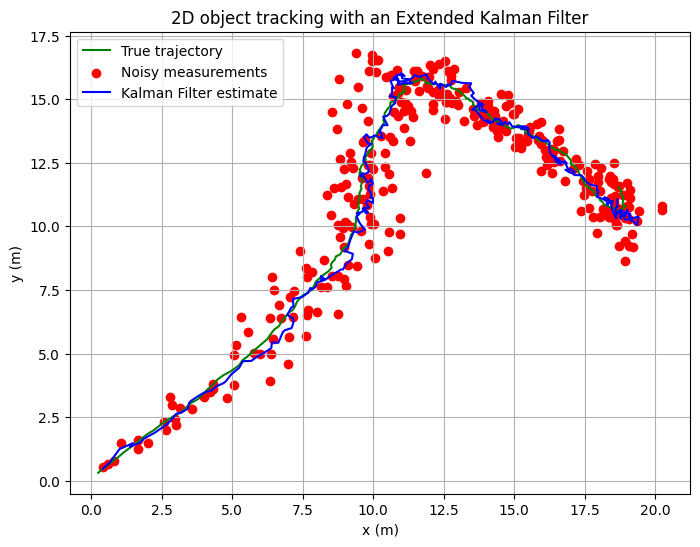

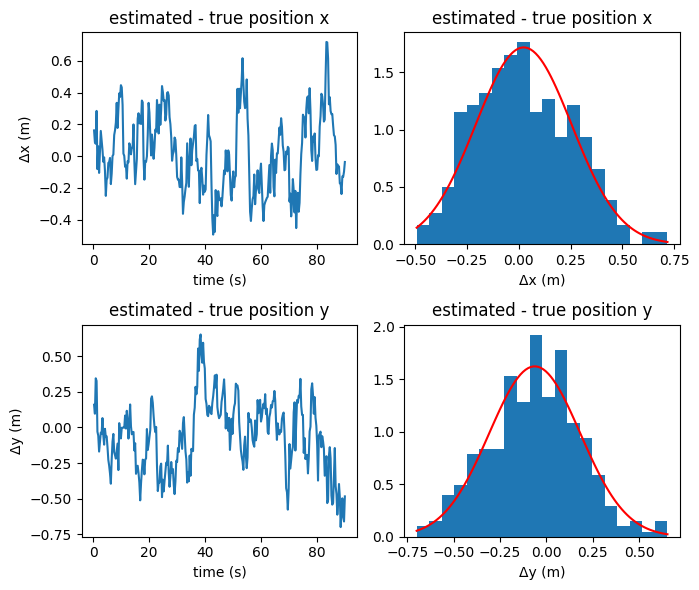

In [26]:
# Inputs for running a 2D example:
# Random number seed (change to None) for randomized seed
seed = 75
# Define time step and total simulation time
dt = 0.3  # Time step (seconds)
c  = 0.1  # Drag coefficient over mass
N  = 300  # Number of time steps
# True initial state vector
st0 = np.array([0., 0., 1., 1.]) # Initial position (0,0) m, velocity (1,1) m/s
# Initial estimates of the state vector and its corresponding covariance matrix
s0 = np.array([0., 0., 1., 1.]) # Initial estimate
C0 = np.eye(4)  # Initial uncertainty
# Define functions to compute the process and measurement noise covariances
def adaptive_process_noise_covariance(st):
    u = np.sqrt(st[2]**2+st[3]**2)
    Q = np.eye(4) * (0.001 + 0.0005*u)
    return Q
def adaptive_measurement_covariance(st):
    r = np.sqrt(st[0]**2+st[1]**2)
    d = np.array([0.25, 0.05/(1+r)])
    R = np.eye(2) * d
    return R
        
motion = MotionWithDrag_RangeAndBearingMeasurements(2,dt,c,adaptive_process_noise_covariance,adaptive_measurement_covariance,seed)

# Generate a true trajectory (a list of N sequential state vectors) by evolving 
# the specified initial state
stl = motion.generate_true_trajectory(N, st0)

# Generate a list of noisy measurements (one for each state vector in the input list).
ml  = motion.generate_noisy_measurements(stl)
                
# Apply an Extended Kalman Filter to obtain estimates of the state vector and covariances 
# at each time step, given the measurements vectors
sl, Cl = motion.predicted_trajectory(ml,s0,C0)

# Plot
plot_trajectories_and_measurements(stl,sl,ml,True,"2D object tracking with an Extended Kalman Filter")
plot_trajectory_estimate_deviations(stl,sl,dt)   

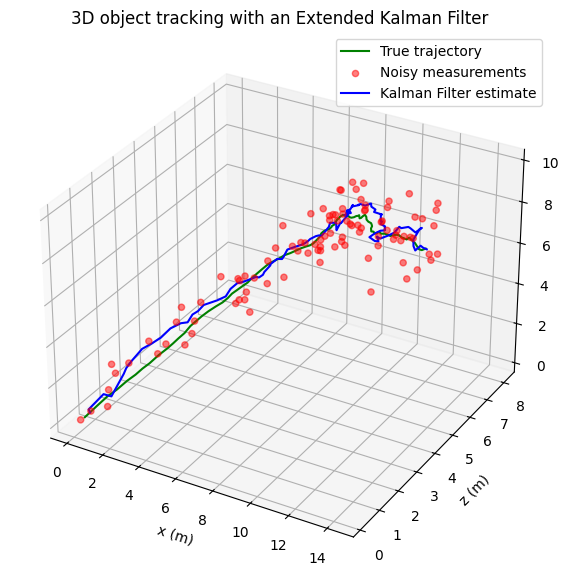

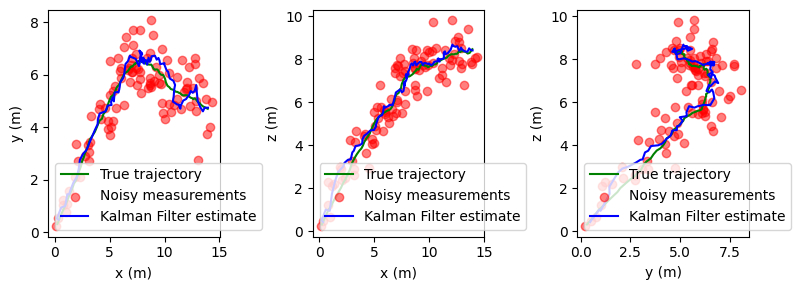

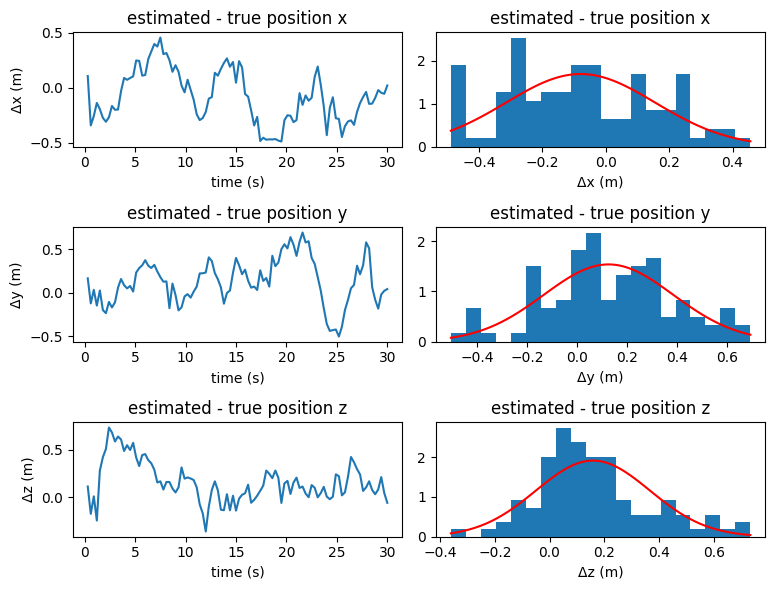

In [27]:
# Inputs for running a 3D example:
# Random number seed (change to None) for randomized seed
seed = 75
# Define time step and total simulation time
dt = 0.3  # Time step (seconds)
c  = 0.1  # Drag coefficient over mass
N  = 100  # Number of time steps
# True initial state vector
st0 = np.array([0., 0., 0., 1., 1., 1.]) # Initial position (0,0,0) m, velocity (1,1,1) m/s
# Initial estimates of the state vector and its corresponding covariance matrix
s0 = np.array([0., 0., 0., 1., 1., 1.]) # Initial estimate
C0 = np.eye(6)  # Initial uncertainty
# Define functions to compute the process and measurement noise covariances
def adaptive_process_noise_covariance(st):
    u = np.sqrt(np.sum(st[3:]**2))
    Q = np.eye(6) * (0.001 + 0.0005*u)
    return Q
def adaptive_measurement_covariance(st):
    r = np.sqrt(np.sum(st[0:3]**2))
    d = np.array([0.25, 0.05/(1+r), 0.05/(1+r)])
    R = np.eye(3) * d
    return R
        
motion = MotionWithDrag_RangeAndBearingMeasurements(3,dt,c,adaptive_process_noise_covariance,adaptive_measurement_covariance,seed)

# Generate a true trajectory (a list of N sequential state vectors) by evolving 
# the specified initial state
stl = motion.generate_true_trajectory(N, st0)

# Generate a list of noisy measurements (one for each state vector in the input list).
ml  = motion.generate_noisy_measurements(stl)
                
# Apply an Extended Kalman Filter to obtain estimates of the state vector and covariances 
# at each time step, given the measurements vectors
sl, Cl = motion.predicted_trajectory(ml,s0,C0)

# # Plot
plot_trajectories_and_measurements(stl,sl,ml,True, "3D object tracking with an Extended Kalman Filter")
plot_trajectory_estimate_deviations(stl,sl,dt)   

## References and suggested reading

\[1\] Rudolph Emil Kalman, A New Approach to Linear Filtering and Prediction Problems, [Transactions of the ASME--Journal of Basic Engineering 82, 35-45 (1960)](https://www.cs.unc.edu/~welch/kalman/media/pdf/Kalman1960.pdf)

\[2\] Kalman Filter, [Wikipedia article](https://en.wikipedia.org/wiki/Kalman_filter)

\[3\] [Tutorials, references, and research related to the Kalman filter](https://www.cs.unc.edu/~welch/kalman/index.html), maintained by Greg Welch and Gary Bishop
